In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import torch

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
def get_dataset(take_first=None):
    fashion_mnist = keras.datasets.fashion_mnist
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    train_images = train_images / 255.0
    test_images = test_images / 255.0

    if take_first is not None:
        train_images = train_images[:take_first, ...]
        train_labels = train_labels[:take_first]
#     train_images = train_images[:, :2, :3]
#     train_images = train_images
    train_labels = np.array([0 if label%2 == 0 else 1.0-(1e-3) for label in train_labels])
        
    train_images = np.expand_dims(train_images, -1)
#     test_images = np.expand_dims(test_images[:,  :2, :3], -1)
    test_images = np.expand_dims(test_images, -1)
    test_labels = np.array([0 if label%2 == 0 else 1.0-(1e-3) for label in test_labels[:take_first]])
        
    return train_images, train_labels, test_images, test_labels

In [3]:
train_images, train_labels, test_images, test_labels = get_dataset()

In [4]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

In [7]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters=2, kernel_size=2, padding='valid', activation='relu',
                               input_shape=(28, 28, 1)),
#                                 input_shape=(2, 3, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)#, activation='softmax')
    ]
)


In [8]:
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.fit(train_images,
          train_labels,
          epochs=1)
model.summary()

Train on 60000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
60000/60000 [==============================] - 11s 179us/sample - loss: 0.0000e+00 - accuracy: 0.4916
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 27, 2)         10        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1458)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1459      
Total params: 1,469
Trainable params: 1,469
Non-trainable params: 0
_________________________________________________________________


In [9]:
for layer in model.layers:
    for t in layer.get_weights():
        print(t.shape)
        
[1, 3, 2, 2]

(2, 2, 1, 2)
(2,)
(1458, 1)
(1,)


[1, 3, 2, 2]

In [10]:
# model.layers[0].set_weights([np.arange(4, dtype=np.float64).reshape((2, 2, 1, 1))/4.0, np.zeros((1,), dtype=np.float64)])
# model.layers[2].set_weights([model.layers[2].get_weights()[0], np.zeros((1,), dtype=np.float64)])

In [11]:
for layer in model.layers:
    for t in layer.get_weights():
        print(t)

[[[[ 0.21420413  0.695429  ]]

  [[-0.19345182 -0.69765073]]]


 [[[ 0.4447332   0.30894715]]

  [[-0.5600252   0.38958198]]]]
[0. 0.]
[[-0.05866317]
 [ 0.01715545]
 [-0.00805628]
 ...
 [-0.02839186]
 [-0.01749746]
 [ 0.02296127]]
[0.]


In [12]:
# print('Evaluate source model')
# test_loss, test_acc = model.evaluate(test_images,
#                                      test_labels,
#                                      verbose=0)
# print('Test accuracy:', test_acc)

In [13]:
def to_tf_kernel_order(tensor):
    """Change conv.kernel axis order from PyTorch to Tensoflow.

    :param tensor: tensor with conv.kernel weights.
    :return: tensor with the Tensoflow-like exis order.
    []
    """
    return np.transpose(tensor, (2, 3, 1, 0))


def to_pytorch_kernel_order(tensor):
    """Change conv.kernel axis order from Tensoflow to PyTorch.

    :param tensor: tensor with conv.kernel weights.
    :return: tensor with the Pytorch-like exis order.
    []
    """
#     (out_channels, in_channels/groups, kernel_size[0],kernel_size[1])
    return np.transpose(tensor, (3, 2, 0, 1))

In [14]:
import torch.nn as nn

In [15]:
torch_model = nn.Sequential(
                            nn.Conv2d(1, 2, kernel_size=2,),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.Linear(10, 1),
#                             nn.Softmax(dim=1)
                           )

In [16]:
con1, conv1_bias, dense, dense_bias = *model.layers[0].get_weights(), *model.layers[-1].get_weights()

In [17]:
con1.shape

(2, 2, 1, 2)

In [18]:
torch_model[0].weight.data = torch.from_numpy(np.transpose(con1, (3, 2, 0, 1))).float()
torch_model[0].bias.data = torch.from_numpy(conv1_bias).float() 

torch_model[-1].weight.data = torch.from_numpy(dense).reshape(-1, 1).T.float()
torch_model[-1].bias.data = torch.from_numpy(dense_bias).float()

In [19]:
np.linalg.norm(con1.T - np.transpose(np.transpose(con1.T, [0, 3, 1, 2]), [0, 2, 3, 1]))

0.0

In [22]:
# torch_test_images = np.transpose(test_images.astype(np.float32), (0, 3, 1, 2))

for idx in range(1):
    src = np.zeros((28*28))
#     src[idx] = 1.0?
    tf_test_image = src.reshape((-1, 28, 28, 1)).astype(np.float32)
#     src = np.zeros((6,))
#     tf_test_image = src.reshape((-1, 2, 3, 1)).astype(np.float32)
    torch_test_image = np.transpose(tf_test_image, (0, 3, 1, 2))

    tf_tensor = tf.keras.backend.get_value(model(tf_test_image))
    torch_answer = torch_model(torch.from_numpy(torch_test_image).float()).data.numpy()
    print(idx, np.linalg.norm(tf_tensor-torch_answer))
    
    conv_torch = tf.keras.backend.get_value(model.layers[0](tf_test_image))
    x = torch_model[0](torch.from_numpy(torch_test_image).float()).data.numpy()
    x = torch_model[1](torch.from_numpy(x).float()).data.numpy()
    print(np.linalg.norm(conv_torch - np.transpose(x, (0, 2, 3, 1))))
    print("================")

0 0.0
0.0


In [23]:
# conv_1, cov1_b = torch_model[0].weight.data, torch_model[0].bias.data
# dense_1, bias_1 = torch_model[-1].weight.data, torch_model[-1].bias.data

# conv_1 = np.transpose(conv_1, (2, 3, 1, 0))

# model.layers[0].set_weights([conv_1, cov1_b])
# model.layers[2].set_weights([dense_1.T, bias_1 ])

In [25]:
from tqdm import tqdm
# torch_test_images = np.transpose(test_images.astype(np.float32), (0, 3, 1, 2))

norms = []
for idx in tqdm(range(1, 100)):
    test = np.random.random([1, 28, 28, 1]).astype(np.float32)
#     test = np.random.random([1, 2, 3, 1]).astype(np.float32)
    test_torch = np.transpose(test, (0, 3, 1, 2))
    tf_tensor = tf.keras.backend.get_value(model(test))
    
    torch_answer = torch_model(torch.from_numpy(test_torch).float()).data.numpy()
    norms.append(np.linalg.norm(tf_tensor-torch_answer))
print("================")

100%|██████████| 99/99 [00:00<00:00, 340.75it/s]

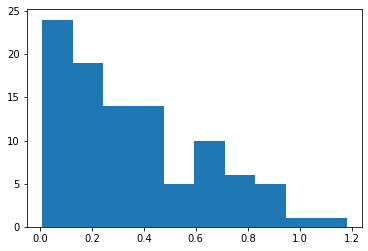

In [26]:
plt.hist(norms)
plt.show()

# Let's compare decompositions

In [27]:
rank = 2
cin = 1
cout = 2
kernel_size = (2, 2)

In [28]:
from sktensor import dtensor, ktensor, cp_als


torch_conv = torch_model[0].weight.data
# torch_conv = np.transpose(torch_model[0].weight.data, (2, 3, 1, 0))
weight_torch = torch_conv.reshape(*torch_conv.shape[:2], -1)

T = dtensor(weight_torch)
np.random.seed(42)
P, fit, itr = cp_als(T, rank, init='random')

toch_cout = np.array(P.U[0]) 
toch_cin = np.array(P.U[1])
toch_z = np.array(P.U[2]*P.lmbda)

toch_cin = toch_cin.T.reshape((rank, cin, 1, 1))
toch_z = toch_z.T.reshape((rank, 1, *kernel_size))
toch_cout = toch_cout.reshape((cout, rank, 1, 1))

In [29]:
toch_cin, toch_z, toch_cout

(array([[[[1.]]],
 
 
        [[[1.]]]]), array([[[[ 0.49552961, -0.51051417],
          [ 0.00160011,  0.7027255 ]]],
 
 
        [[[ 0.63129168, -0.62210904],
          [ 0.46308587, -0.00162228]]]]), array([[[[-0.7947097 ]],
 
         [[ 0.96311474]]],
 
 
        [[[ 0.55592285]],
 
         [[ 0.66522782]]]]))

In [30]:
from sktensor import dtensor, ktensor, cp_als

tf_conv = np.transpose(model.layers[0].get_weights()[0], (3, 2, 0, 1))
# tf_conv = model.layers[0].get_weights()[0]
weight_tf = tf_conv.reshape((*tf_conv.shape[:2], -1))

T = dtensor(weight_tf)
np.random.seed(42)
P, fit, itr = cp_als(T, rank, init='random')

tf_cout = np.array(P.U[0]) 
tf_cin = np.array(P.U[1])
tf_z = np.array(P.U[2]*P.lmbda)

tf_cin = tf_cin.T.reshape((rank, cin, 1, 1))
tf_z = tf_z.T.reshape((rank, 1, *kernel_size))
tf_cout = tf_cout.reshape((cout, rank, 1, 1))

[tf_cin, tf_z, tf_cout]=[np.transpose(tensor, (2, 3, 1, 0)) for tensor in [tf_cin, tf_z, tf_cout]]

In [31]:
tf_cin.shape, tf_z.shape, tf_cout.shape

((1, 1, 1, 2), (2, 2, 1, 2), (1, 1, 2, 2))

# Load decomposed layers back
## Pytorch

In [32]:
new_torch_model = nn.Sequential(
                            nn.Conv2d(in_channels=cin,
                                    out_channels=rank,
                                    kernel_size = (1, 1)),
                            nn.Conv2d(in_channels = rank, 
                                    out_channels=rank,
                                    kernel_size = kernel_size,
                                    groups = int(rank)),
                            nn.Conv2d(in_channels = rank,
                                    out_channels = cout, 
                                    kernel_size = (1, 1)),

                           )

new_torch_model[0].weight.data = torch.from_numpy(toch_cin).float()
new_torch_model[0].bias.data = torch.zeros_like(new_torch_model[0].bias.data)

new_torch_model[1].weight.data = torch.from_numpy(toch_z).float()
new_torch_model[1].bias.data = torch.zeros_like(new_torch_model[1].bias.data)

new_torch_model[2].weight.data = torch.from_numpy(toch_cout).float()
new_torch_model[2].bias.data = torch_model[0].bias.data

# new_torch_model[-1].weight.data = torch_model[-1].weight.data
# new_torch_model[-1].bias.data = torch_model[-1].bias.data

In [33]:
# test = torch.from_numpy(np.transpose(np.random.random([1, 28, 28, 1]).astype(np.float32), (0, 3, 1, 2))).float()
test = torch.from_numpy(np.transpose(np.random.random([1, 2, 3, 1]).astype(np.float32), (0, 3, 1, 2))).float()

old_answer = torch_model[0](test).data.numpy()
new_answer = new_torch_model(test).data.numpy()

np.linalg.norm(old_answer - new_answer)

6.6744064e-08

(1, 2, 2, 3)


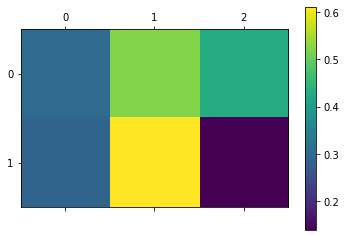

(1, 2, 1, 2)


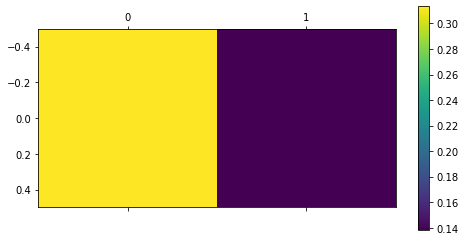

(1, 2, 1, 2)


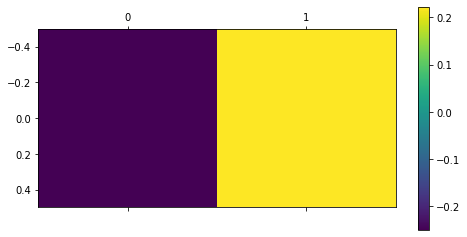

In [34]:
# test = torch.from_numpy(np.transpose(np.random.random([1, 28, 28, 1]).astype(np.float32), (0, 3, 1, 2))).float()
# tf_test = np.random.random([1, 28, 28, 1]).astype(np.float32)
tf_test = np.random.random([1, 2, 3, 1]).astype(np.float32)
torch_test = torch.from_numpy(np.transpose(tf_test, (0, 3, 1, 2))).float()

inputs = torch_test
conv_result = []
for layer in  new_torch_model:
    inputs = layer(inputs)
    np_inputs = inputs.data.numpy()
    conv_result.append(np_inputs)
    print(np_inputs.shape)
    plt.matshow(np_inputs[0, 0, ...])
    plt.colorbar()
    plt.show()

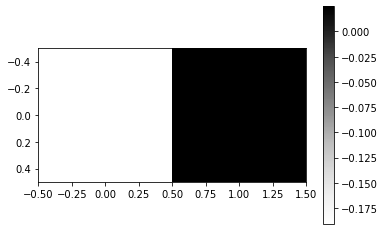

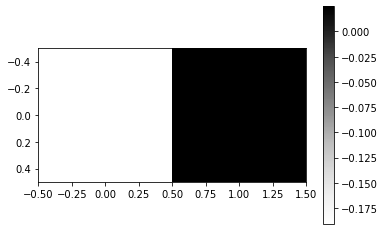

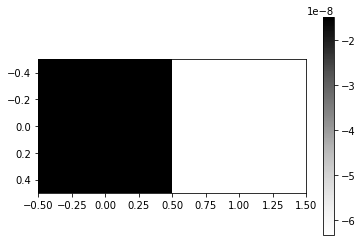

In [35]:
plt.imshow(old_answer[0, 0, ...], cmap='Greys')
plt.colorbar()
plt.show()

plt.imshow(new_answer[0, 0, ...], cmap='Greys')
plt.colorbar()
plt.show()

plt.imshow(new_answer[0, 0, ...] - old_answer[0, 0, ...], cmap='Greys')
plt.colorbar()
plt.show()

## TensorFlow

In [36]:
con1, conv1_bias = model.layers[0].get_weights()
dense, dense_bias = model.layers[-1].get_weights()

In [37]:
np.transpose(tf_z, (0, 1, 3, 2)).shape
# filter_height, filter_width, in_channels, channel_multiplier

(2, 2, 2, 1)

In [38]:
tf_z.shape

(2, 2, 1, 2)

In [39]:
toch_z

array([[[[ 0.49552961, -0.51051417],
         [ 0.00160011,  0.7027255 ]]],


       [[[ 0.63129168, -0.62210904],
         [ 0.46308587, -0.00162228]]]])

In [40]:
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import activations
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.engine import InputSpec


class GroupConv2D(layers.Layer):
    def __init__(self, 
               rank,
               n_group,
               kernel_size,
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation=None,
               use_bias=False,
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
        super(GroupConv2D, self).__init__(**kwargs)
        
        self.rank=rank
        self.kernel_size=kernel_size
        self.strides=strides
        self.padding=padding
        self.data_format=data_format
        self.dilation_rate=dilation_rate
        self.activation=activations.get(activation)
        self.use_bias=use_bias
        self.kernel_initializer=initializers.get(kernel_initializer)
        self.bias_initializer=initializers.get(bias_initializer)
        self.kernel_regularizer=regularizers.get(kernel_regularizer)
        self.bias_regularizer=regularizers.get(bias_regularizer)
        self.activity_regularizer=regularizers.get(activity_regularizer)
        self.kernel_constraint=constraints.get(kernel_constraint)
        self.bias_constraint=constraints.get(bias_constraint)
        self.n_group = n_group
        
    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
     
        channel_axis = -1

        input_dim = int(input_shape[channel_axis])
        kernel_shape = self.kernel_size + (input_shape[-1]/self.n_group, self.rank)

        self.kernel = self.add_variable(name='kernel',
                                        shape=kernel_shape,
                                        initializer=self.kernel_initializer,
                                        regularizer=self.kernel_regularizer,
                                        constraint=self.kernel_constraint,
                                        trainable=True,
                                        dtype=self.dtype)
        if self.use_bias:
            self.bias = self.add_variable(name='bias',
                                        shape=(self.rank,),
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint,
                                        trainable=True,
                                        dtype=self.dtype)
        else:
            self.bias = None
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

        
    def call(self, inputs):
        groupConv = lambda i, k: tf.nn.conv2d(i, 
                                              k, 
                                              strides=[1, self.strides[0], self.strides[1], 1], 
                                              padding=self.padding.upper())        
        if self.n_group == 1:
                outputs = groupConv(inputs, self.kernel)
        else:
            inputGroups = tf.split(axis=3, num_or_size_splits=self.n_group, value=inputs)
            weightsGroups = tf.split(axis=3, num_or_size_splits=self.n_group, value=self.kernel)
            convGroups = [groupConv(i, k) for i, k in zip(inputGroups, weightsGroups)]

            outputs = tf.concat(axis=3, values=convGroups)

        if self.use_bias:
            if layer.data_format != 'channel_last' is None:
                raise ValueError('NHWC only.')
            outputs = nn.bias_add(outputs, self.bias, data_format='NHWC')

        if self.activation is not None:
            return self.activation(outputs)

        
    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape).as_list()
   
        space = input_shape[1:-1]
        new_space = []
        for i in range(len(space)):
            new_dim = conv_utils.conv_output_length(
                                                    space[i],
                                                    self.kernel_size[i],
                                                    padding=self.padding,
                                                    stride=self.strides[i],
                                                    dilation=self.dilation_rate[i])
            new_space.append(new_dim)
        
        return tensor_shape.TensorShape([input_shape[0]] + new_space +[self.filters])
    
    def get_config(self):
        config = {
            
            'n_group': self.n_group,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(Layer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

        

In [41]:
tf_test.shape

(1, 2, 3, 1)

In [42]:
group_layer = keras.Sequential([GroupConv2D(2, n_group=1, 
                          kernel_size=(2,2), 
                          padding='valid', 
                          kernel_initializer=tf.constant_initializer(tf_z))])

group_layer.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [43]:
new_tensor = tf_test
new_tensor = tf.keras.backend.get_value(group_layer(new_tensor))

Instructions for updating:
Please use `layer.add_weight` method instead.


In [44]:
new_tensor.shape

(1, 1, 2, 2)

In [45]:
!pip3 install progressbar

You should consider upgrading via the 'pip install --upgrade pip' command.


In [46]:
kernel_size=(2,2)

import itertools



new_tf_model =  tf.keras.Sequential([
                                    tf.keras.layers.Conv2D(filters=rank,
                                                          kernel_size=1,
                                                          padding='same',
                                                          kernel_initializer=tf.constant_initializer(tf_cin),
                                                          bias_initializer='zeros',

                                                          ),
                                    GroupConv2D(rank=2, 
                                                n_group=2, 
                                                kernel_size=(2,2), 
                                                padding='valid', 
                                                kernel_initializer=tf.constant_initializer(tf_z)),
                                    tf.keras.layers.Conv2D(filters=2,
                                                        kernel_size=1,
                                                        padding='valid',
                                                        kernel_initializer=tf.constant_initializer(tf_cout),
                                                        bias_initializer=tf.constant_initializer(conv1_bias),
                                                        ),
]
)


new_tensors = []
new_tensor = tf_test
new_tensor = tf.keras.backend.get_value(new_tf_model.layers[0](new_tensor))
new_tensors.append(np.transpose(new_tensor, (0, 3, 1, 2)))

print(new_tensor.shape, tf_cin.shape)

group_layer = keras.Sequential([])
new_tensor = tf.keras.backend.get_value(new_tf_model.layers[1](new_tensor))
new_tensors.append(np.transpose(new_tensor, (0, 3, 1, 2)))

new_tensor = tf.keras.backend.get_value(new_tf_model.layers[2](new_tensor))
new_tensors.append(np.transpose(new_tensor, (0, 3, 1, 2)))
print(new_tensor.shape, tf_cout.shape)

print(new_tensors[0][0, 0, ...]-conv_result[0][0, 0, ...])
print(new_tensors[1][0, 0, ...]-conv_result[1][0, 0, ...])
print(new_tensors[2][0, 0, ...]-conv_result[2][0, 0, ...])
#     print(new_tensors[0][0, 0, ...]-conv_result[0][0, 0, ...])

(1, 2, 3, 2) (1, 1, 1, 2)
(1, 1, 2, 2) (1, 1, 2, 2)
[[0. 0. 0.]
 [0. 0. 0.]]
[[ 0.0000000e+00 -1.4901161e-08]]
[[2.9802322e-08 1.4901161e-08]]


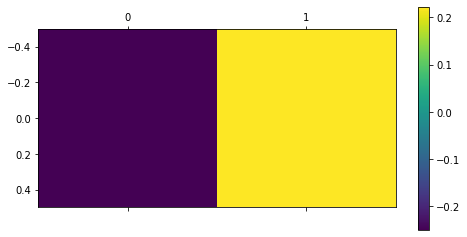

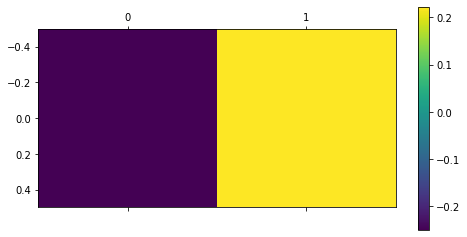

[[2.9802322e-08 1.4901161e-08]]


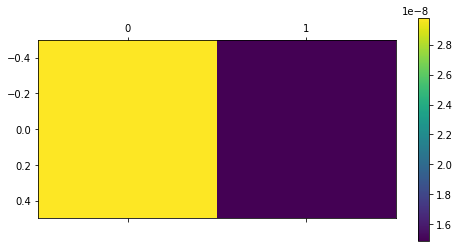

In [47]:
idx = 2
plt.matshow(conv_result[idx][0, 0, ...])
plt.colorbar()
plt.show()

plt.matshow(new_tensors[idx][0, 0, ...])
plt.colorbar()
plt.show()

plt.matshow(new_tensors[idx][0, 0, ...]-conv_result[idx][0, 0, ...])
print(new_tensors[idx][0, 0, ...]-conv_result[idx][0, 0, ...])
plt.colorbar()
plt.show()